# 07g scATAC seq further processing MPPs

analysis of scATAC seq in MPPs using Signac

used this docker image

docker run 
--rm 
-d 
--name signac 
-p 8880:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
signac_seurat:vs5

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.2”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

In [2]:
MPP <- readRDS("./sc_objects/scATAC_MPP_processed.rds")

In [3]:
library(BSgenome.Mmusculus.UCSC.mm10)

Loading required package: BSgenome
Loading required package: Biostrings
Loading required package: XVector

Attaching package: 'XVector'

The following object is masked from 'package:purrr':

    compact


Attaching package: 'Biostrings'

The following object is masked from 'package:base':

    strsplit

Loading required package: rtracklayer


In [4]:
# Get a list of motif position frequency matrices from the JASPAR database
DefaultAssay(MPP) <- 'peaks'
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

# Scan the DNA sequence of each peak for the presence of each motif
motif.matrix <- CreateMotifMatrix(
  features = StringToGRanges(rownames(MPP), sep = c(":", "-")),
  pwm = pfm,
  genome = 'mm10',
  sep = c(":", "-"),
  use.counts = FALSE
)

# Create a new Mofif object to store the results
motif <- CreateMotifObject(
  data = motif.matrix,
  pwm = pfm
)

# Add the Motif object to the assay
MPP[['peaks']] <- AddMotifObject(
  object = MPP[['peaks']],
  motif.object = motif
)

# calculates sequence statistics for motif enrichment

MPP <- RegionStats(
  object = MPP,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  sep = c(":", "-")
)

In [5]:
MPP <- RunChromVAR(
  object = MPP,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

DefaultAssay(MPP) <- 'chromvar'

Computing GC bias per region
Selecting background regions
Computing motif deviations from background
Constructing chromVAR assay


In [6]:
# calculate motif enrichment for each cluster

DefaultAssay(MPP) <- 'chromvar'
MPP.markers_cv <- FindAllMarkers(MPP, only.pos = TRUE, min.pct = 0.10, logfc.threshold = 0.25)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12


In [7]:
motifnames <- GetMotifData(object = MPP, assay = 'peaks', slot = 'motif.names')
motifnames <- t(as.data.frame((motifnames)))
colnames(motifnames) <- c("gene_name")
motifnames <- data.frame(gene = row.names(motifnames), motifnames)
MPP.markers_cv <- merge(MPP.markers_cv, motifnames, by = 'gene')

In [8]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 0))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0009.2,4.944331e-41,0.4284114,0.583,0.432,2.234837e-38,0,T
MA0014.3,3.308366e-40,0.3332933,0.584,0.434,1.495381e-37,0,PAX5
MA0017.2,2.094548e-33,0.3705292,0.546,0.413,9.467356e-31,0,NR2F1
MA0018.3,5.710052e-27,0.3225345,0.559,0.450,2.580943e-24,0,CREB1
MA0030.1,1.315630e-30,0.3004680,0.577,0.438,5.946649e-28,0,FOXF2
MA0032.2,8.548999e-46,0.3720546,0.563,0.407,3.864147e-43,0,FOXC1
MA0039.3,7.302992e-52,0.3493412,0.578,0.407,3.300953e-49,0,KLF4
MA0046.2,3.562949e-49,0.4229260,0.567,0.408,1.610453e-46,0,HNF1A
MA0048.2,9.640803e-59,0.7433095,0.591,0.412,4.357643e-56,0,NHLH1


In [9]:
head(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 1))

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>


In [10]:
head(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 2))

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>


In [11]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 3))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0018.3,9.013338e-37,0.2936061,0.638,0.454,4.074029e-34,3,CREB1
MA0099.3,4.634437e-275,4.7567598,0.909,0.417,2.094765e-272,3,FOS::JUN
MA0462.1,4.648202e-196,1.9684255,0.857,0.433,2.100987e-193,3,BATF::JUN
MA0476.1,1.634189e-267,4.1894972,0.900,0.418,7.386535e-265,3,FOS
MA0477.1,5.572883e-287,3.8707187,0.927,0.417,2.518943e-284,3,FOSL1
MA0478.1,1.235531e-283,3.8225306,0.929,0.418,5.584600e-281,3,FOSL2
MA0489.1,4.072132e-273,2.8176123,0.907,0.417,1.840604e-270,3,JUN(var.2)
MA0490.1,2.204850e-289,3.7156380,0.931,0.417,9.965921e-287,3,JUNB
MA0491.1,4.894664e-279,3.7337182,0.912,0.413,2.212388e-276,3,JUND


In [12]:
head(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 4))

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>


In [13]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 5))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0003.3,2.700101e-21,0.4275046,0.612,0.459,1.220446e-18,5,TFAP2A
MA0017.2,4.216986e-32,0.7025350,0.640,0.426,1.906078e-29,5,NR2F1
MA0025.1,3.366415e-32,0.5899497,0.651,0.448,1.521620e-29,5,NFIL3
MA0030.1,2.030189e-18,0.4504827,0.596,0.458,9.176455e-16,5,FOXF2
MA0031.1,1.519117e-21,0.4283745,0.624,0.463,6.866409e-19,5,FOXD1
MA0032.2,3.481120e-22,0.3340681,0.612,0.427,1.573466e-19,5,FOXC1
MA0033.2,1.217139e-32,0.6420502,0.653,0.457,5.501469e-30,5,FOXL1
MA0036.3,5.894421e-38,1.0100219,0.691,0.479,2.664278e-35,5,GATA2
MA0037.3,4.250935e-39,0.8938564,0.687,0.485,1.921423e-36,5,GATA3


In [14]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 6))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0003.3,1.333630e-29,0.4265727,0.648,0.456,6.028007e-27,6,TFAP2A
MA0009.2,3.273785e-14,0.2545305,0.592,0.455,1.479751e-11,6,T
MA0014.3,3.717083e-16,0.4094679,0.602,0.456,1.680122e-13,6,PAX5
MA0017.2,7.091778e-47,0.6051676,0.683,0.424,3.205484e-44,6,NR2F1
MA0018.3,2.095063e-28,0.5115663,0.647,0.461,9.469683e-26,6,CREB1
MA0025.1,1.642436e-18,0.3908897,0.614,0.451,7.423809e-16,6,NFIL3
MA0030.1,1.015459e-16,0.3520046,0.617,0.457,4.589874e-14,6,FOXF2
MA0031.1,1.139633e-08,0.2900093,0.580,0.467,5.151139e-06,6,FOXD1
MA0032.2,2.292885e-30,0.5123006,0.643,0.426,1.036384e-27,6,FOXC1


In [15]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 7))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0003.3,7.843286e-07,0.3751131,0.569,0.464,3.545165e-04,7,TFAP2A
MA0009.2,4.218591e-19,0.5915043,0.623,0.455,1.906803e-16,7,T
MA0014.3,3.903012e-10,0.2813015,0.564,0.460,1.764161e-07,7,PAX5
MA0017.2,3.966148e-48,0.9030907,0.708,0.426,1.792699e-45,7,NR2F1
MA0018.3,8.874878e-24,0.7210000,0.651,0.463,4.011445e-21,7,CREB1
MA0039.3,9.471722e-53,0.7868191,0.736,0.427,4.281218e-50,7,KLF4
MA0046.2,7.344473e-13,0.3028325,0.573,0.434,3.319702e-10,7,HNF1A
MA0048.2,4.140818e-25,0.5338101,0.649,0.439,1.871650e-22,7,NHLH1
MA0052.3,2.487223e-09,0.2754071,0.547,0.417,1.124225e-06,7,MEF2A


In [16]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 8))[1:20,]

,gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,MA0024.3,1.108380e-07,0.3764503,0.604,0.475,5.009877e-05,8,E2F1
2,MA0028.2,1.135844e-05,0.8757311,0.543,0.444,5.134017e-03,8,ELK1
3,MA0036.3,5.295150e-117,2.2024626,0.938,0.476,2.393408e-114,8,GATA2
4,MA0037.3,7.837011e-104,2.0967577,0.938,0.482,3.542329e-101,8,GATA3
5,MA0046.2,4.607239e-05,0.2891558,0.545,0.438,2.082472e-02,8,HNF1A
6,MA0079.3,2.050397e-22,0.2670672,0.701,0.448,9.267796e-20,8,SP1
7,MA0140.2,4.449119e-130,2.5564543,0.965,0.476,2.011002e-127,8,GATA1::TAL1
8,MA0470.1,5.108680e-05,1.3722292,0.519,0.444,2.309123e-02,8,E2F4
9,MA0502.1,2.767058e-11,0.3494641,0.628,0.490,1.250710e-08,8,NFYB


In [17]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 9))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0014.3,2.196912e-10,0.5596146,0.757,0.463,9.930043e-08,9,PAX5
MA0017.2,6.659386e-07,0.7088908,0.703,0.439,3.010042e-04,9,NR2F1
MA0024.3,1.678439e-06,0.7573799,0.676,0.478,7.586544e-04,9,E2F1
MA0025.1,3.713589e-11,1.0011500,0.770,0.460,1.678542e-08,9,NFIL3
MA0028.2,5.509679e-22,1.3199283,0.865,0.444,2.490375e-19,9,ELK1
MA0032.2,3.379798e-08,0.8219219,0.716,0.438,1.527669e-05,9,FOXC1
MA0039.3,2.112931e-05,0.5158663,0.635,0.442,9.550447e-03,9,KLF4
MA0043.2,5.816530e-23,2.4418186,0.851,0.464,2.629071e-20,9,HLF
MA0046.2,9.972424e-14,1.1823448,0.757,0.439,4.507536e-11,9,HNF1A


In [18]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 10))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0025.1,3.643398e-09,1.0731672,0.833,0.460,1.646816e-06,10,NFIL3
MA0028.2,6.889997e-20,2.1222266,0.952,0.446,3.114279e-17,10,ELK1
MA0032.2,7.540823e-07,0.5848502,0.762,0.439,3.408452e-04,10,FOXC1
MA0036.3,2.484626e-10,1.8040657,0.833,0.492,1.123051e-07,10,GATA2
MA0037.3,1.347940e-07,1.8655703,0.738,0.498,6.092689e-05,10,GATA3
MA0043.2,2.742010e-14,1.2074942,0.905,0.465,1.239389e-11,10,HLF
MA0046.2,2.018471e-08,0.7928517,0.786,0.440,9.123489e-06,10,HNF1A
MA0076.2,2.517022e-14,1.4204656,0.881,0.443,1.137694e-11,10,ELK4
MA0084.1,4.377186e-06,0.8950258,0.762,0.458,1.978488e-03,10,SRY


In [19]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 11))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0024.3,8.804565e-08,1.0192065,0.854,0.478,3.979664e-05,11,E2F1
MA0025.1,8.636855e-09,0.7986407,0.805,0.461,3.903859e-06,11,NFIL3
MA0028.2,1.684486e-20,2.8375402,0.927,0.446,7.613875e-18,11,ELK1
MA0030.1,1.636403e-05,0.6310361,0.732,0.466,7.396542e-03,11,FOXF2
MA0031.1,6.547322e-08,0.6103248,0.780,0.473,2.959389e-05,11,FOXD1
MA0032.2,2.340411e-10,1.0787474,0.878,0.438,1.057866e-07,11,FOXC1
MA0043.2,8.054572e-05,0.3983327,0.732,0.466,3.640667e-02,11,HLF
MA0046.2,6.825366e-09,1.3257473,0.829,0.440,3.085065e-06,11,HNF1A
MA0050.2,4.399837e-06,0.4490909,0.732,0.400,1.988726e-03,11,IRF1


In [20]:
(MPP.markers_cv %>% filter(p_val_adj < 0.05) %>% filter(cluster == 12))[1:20,]

gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MA0028.2,1.388774e-13,3.6019202,1.000,0.447,6.277259e-11,12,ELK1
MA0030.1,2.602591e-06,0.9674386,0.895,0.467,1.176371e-03,12,FOXF2
MA0031.1,6.654992e-05,0.7338667,0.842,0.473,3.008056e-02,12,FOXD1
MA0032.2,4.695828e-11,1.6632402,1.000,0.439,2.122514e-08,12,FOXC1
MA0046.2,1.384288e-07,1.3852965,0.947,0.441,6.256980e-05,12,HNF1A
MA0050.2,7.061828e-12,2.0195196,0.947,0.401,3.191946e-09,12,IRF1
MA0051.1,4.447500e-11,3.2529183,0.947,0.433,2.010270e-08,12,IRF2
MA0052.3,2.412575e-07,1.1720953,0.895,0.423,1.090484e-04,12,MEF2A
MA0076.2,1.996519e-09,1.1999126,1.000,0.444,9.024267e-07,12,ELK4


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


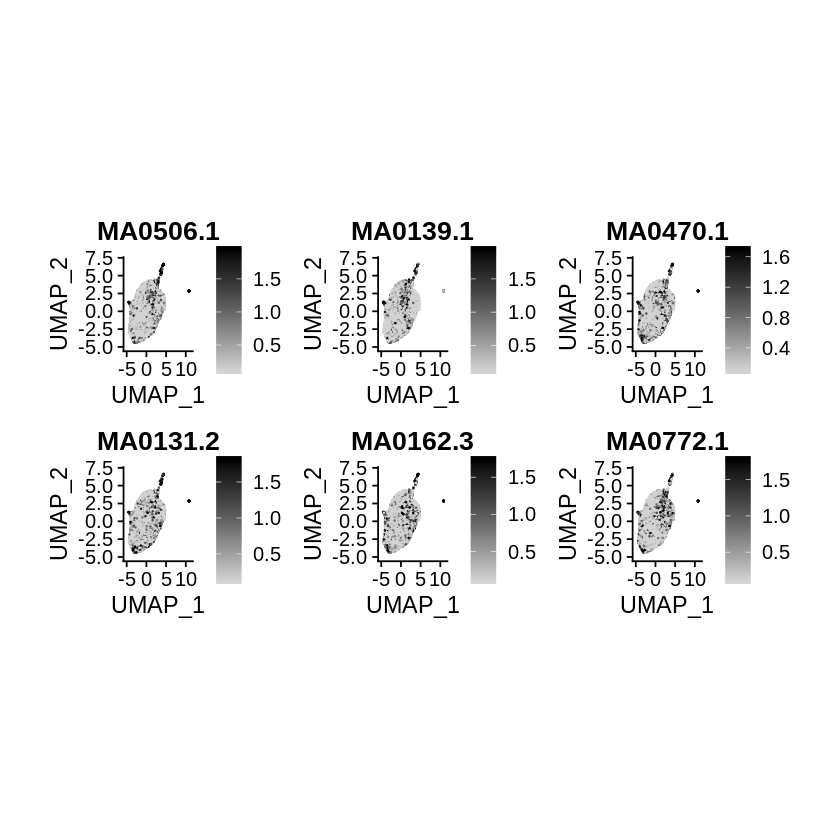

In [41]:
plot = FeaturePlot(
  object = MPP,
  features = c(
               'MA0506.1',
               'MA0139.1',
                "MA0470.1",
                'MA0131.2',
                'MA0162.3',
                'MA0772.1'
                ),
  cols = c('lightgrey', 'black'),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.08,
  ncol = 3,
)

plot + coord_fixed(ratio = 0.55)


In [42]:
#save plot
ggsave('MPP_6_motifs.pdf', plot = last_plot(), width = 12, height = 5, device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

In [43]:
#save plot
ggsave('MPP_6_motifs.jpg', plot = last_plot(), width = 12, height = 5, device = 'jpg', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

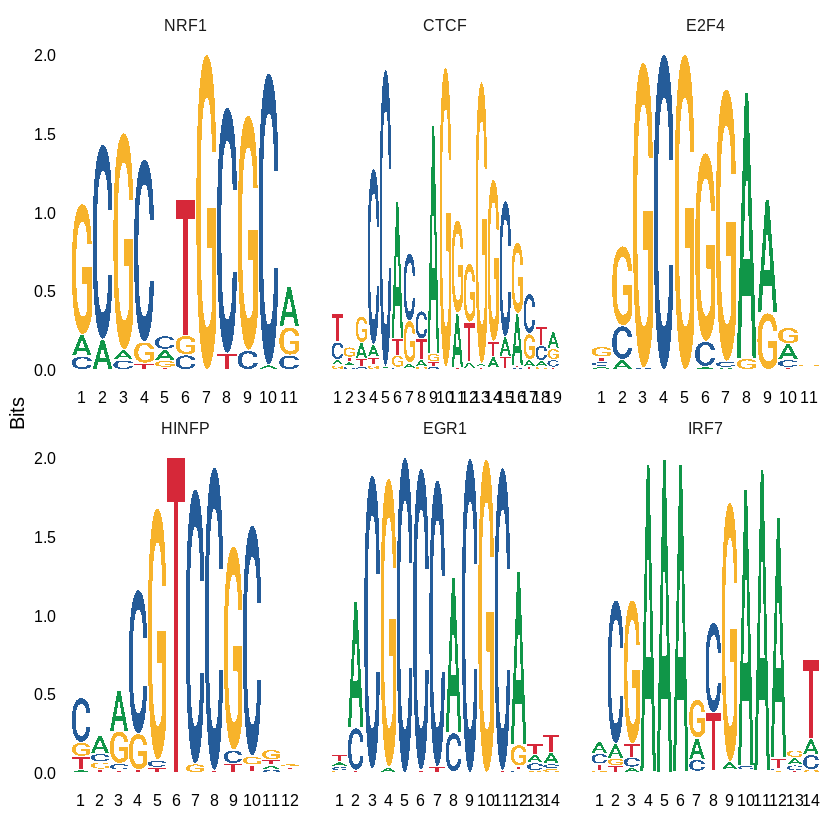

In [44]:
MotifPlot(
  object = MPP,
  motifs = c(
               'MA0506.1',
               'MA0139.1',
                "MA0470.1",
                  'MA0131.2',
                  'MA0162.3',
                  'MA0772.1'),
  assay = 'peaks'
)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


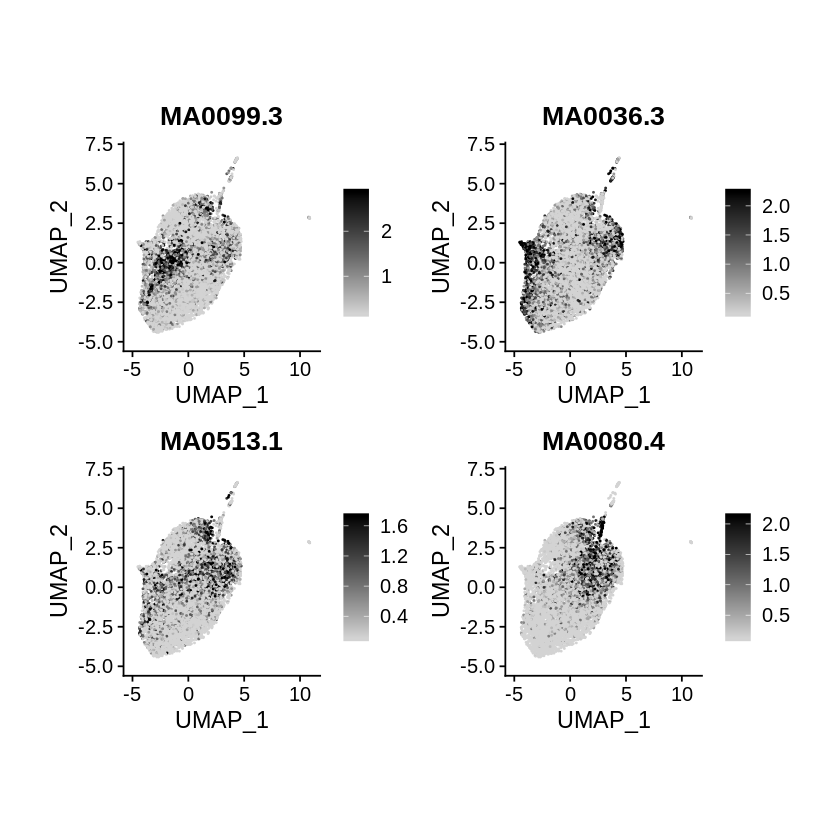

In [45]:
plot = FeaturePlot(
  object = MPP,
  features = c(
               'MA0099.3',
               'MA0036.3',
               "MA0513.1",
                "MA0080.4"
                ),
  cols = c('lightgrey', 'black'),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.15,
  ncol = 2,
)

plot + coord_fixed(ratio = 0.85)

In [46]:
#save plot
ggsave('MPP_4_motifs.pdf', plot = last_plot(), device = 'pdf', path = './figures/',
       scale = 0.9, units = 'in', dpi = 300)

Saving 6 x 6 in image


In [47]:
#save plot
ggsave('MPP_4_motifs.jpg', plot = last_plot(), device = 'jpg', path = './figures/',
       scale = 0.9, units = 'in', dpi = 300)

Saving 6 x 6 in image


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


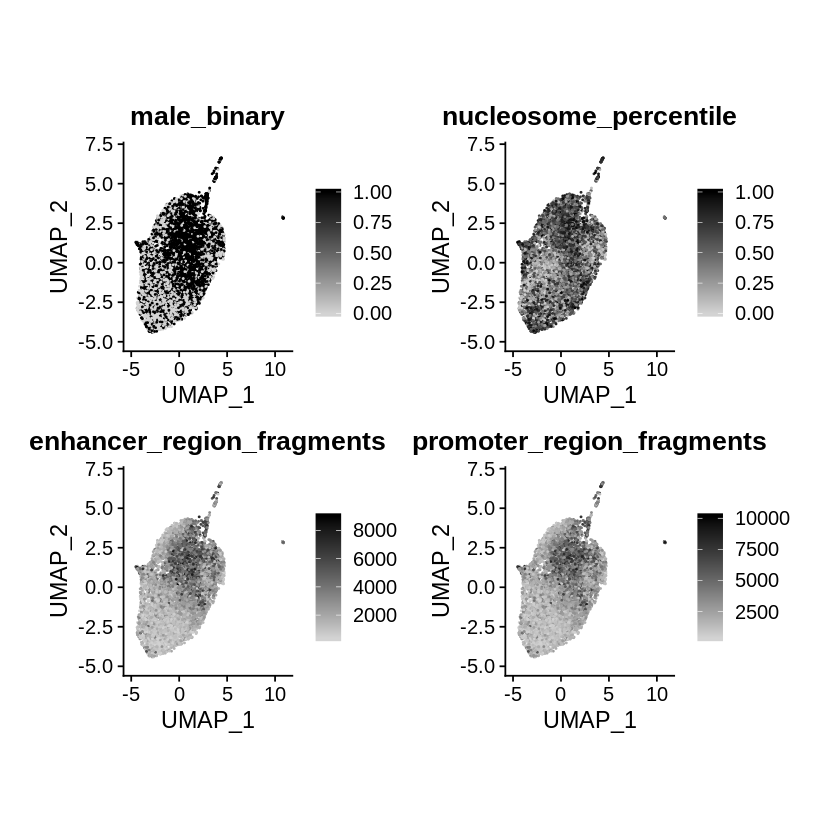

In [48]:
baseplot = FeaturePlot(MPP, features = c("male_binary", 
                               "nucleosome_percentile", 
                               'enhancer_region_fragments',
                               'promoter_region_fragments'
                               ), 
                              cols = c('lightgrey', 'black'),
                              pt.size = 0.15,
                              
                              )

baseplot + coord_fixed(ratio = 0.85) 


In [49]:
#save plot
ggsave('MPP_generalstats.pdf', plot = last_plot(), device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Saving 6.67 x 6.67 in image


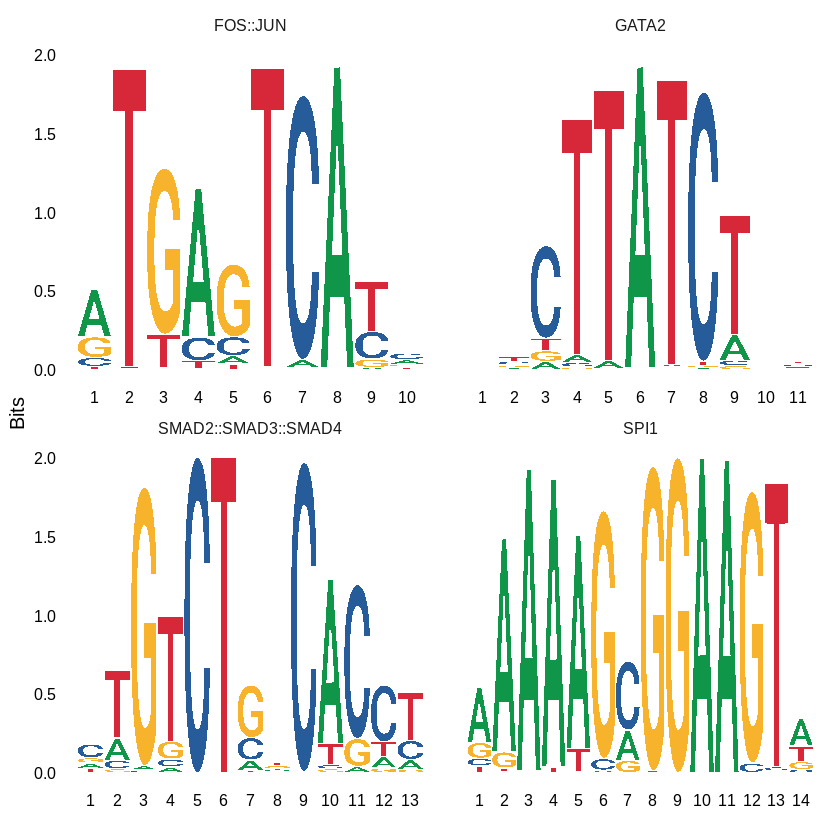

In [50]:
MotifPlot(
  object = MPP,
  motifs = c(
               'MA0099.3',
               'MA0036.3',
               "MA0513.1",
                "MA0080.4"),
  assay = 'peaks'
)

The following functions and any applicable methods accept the dots: CombinePlots
Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
"

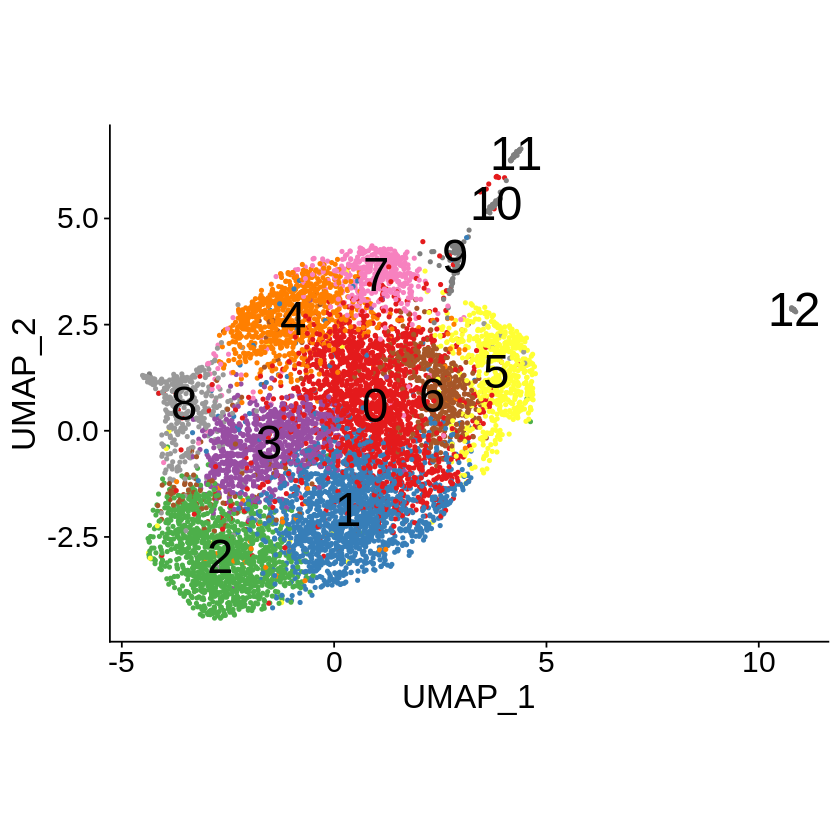

In [51]:
baseplot = DimPlot(object = MPP,
                    label = TRUE,
                    cols = 'Set1',
                    pt.size = 0.8,
                    label.size = 10,
                    vector.friendly = TRUE
                    
                        )

baseplot + 
FontSize(x.title = 20, y.title = 20) + coord_fixed(ratio = 1) +
theme(axis.text.x = element_text(size=18), axis.text.y = element_text(size=18)) +
NoLegend()

In [52]:
#save plot
ggsave('scATAC_cluster_MPP.pdf', plot = last_plot(), device = 'pdf', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Saving 6.67 x 6.67 in image
Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
"

In [53]:
#save plot
ggsave('scATAC_cluster_MPP.jpg', plot = last_plot(), device = 'jpg', path = './figures/',
       scale = 1, units = 'in', dpi = 300)

Saving 6.67 x 6.67 in image
Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
"

In [54]:
# write out csvs of motif enrichments

write.csv(MPP.markers_cv,'./write/MPP_markers_cv.csv')

In [55]:
# with chromvar

### save MMP object

saveRDS(MPP, file = "./sc_objects/scATAC_MPP_processed_chromvar.rds")

In [56]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Mmusculus.UCSC.mm10_1.4.0 BSgenome_1.54.0                   
 [3] rtracklayer_1.46.0                 Biostrings_2.54.0                 
 [5] XVector_0.26.0                     forcats_0.4.0                     
 [7] stringr_1.4.0                      dplyr_0.8.4                       
 